# Classification

Download sample MNIST data

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X,y = mnist.data,mnist.target

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

Plotting Sample Data

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.imshow( X[0].reshape(28, 28), cmap='binary')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Train with SGD Classifier

Only do Binary of 5 or not-5

In [8]:
y_test_5 = y_test == 5
y_train_5 = y_train == 5

In [9]:
from sklearn.linear_model import SGDClassifier

In [10]:
sgd = SGDClassifier(random_state=4, tol=1000)
sgd.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=4, shuffle=True, tol=1000,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd.predict(X[:10]), y_train_5[:10] ## Always put an array in predict

(array([ True, False, False, False, False, False, False, False, False,
        False]),
 array([ True, False, False, False, False, False, False, False, False,
        False]))

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring='accuracy')

## High Accuracy, but at what cost?

array([0.9597 , 0.96405, 0.9552 ])

## Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict

# Just like cross_val_score, but return the predictions
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3) 

In [14]:
y_train_pred.shape, y_train.shape # Note: same shape, uses prediction from K-fold concatinated in chunks

((60000,), (60000,))

In [15]:
"""
(Actual,Predicted)

      (-)  <- Predicted -> (+)
      -----------------------------------------------
 -    | True Negative  (-,-) | False Positive (-,+) |
      -----------------------------------------------
 +    | False Netative (+,-) | True Positive  (+,+) |
      -----------------------------------------------
Actual

"""

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_train_5, y_train_pred)
conf

array([[53635,   944],
       [ 1477,  3944]])

In [16]:
(tn, fp), (fn , tp) = conf

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [18]:
# Precision - True positives ratio with false positive in consideration
precision_score(y_train_5, y_train_pred), tp / (tp + fp)

(0.806873977086743, 0.806873977086743)

In [19]:
# Recall - True positives ratio with false negatives (rejected values that shouldn't) in consideration
recall_score(y_train_5, y_train_pred), tp / (tp + fn)

(0.7275410440878067, 0.7275410440878067)

In [20]:
#Accuracy - right answers / counts
np.sum(y_train_5 == y_train_pred) / y_train_pred.shape[0], (tp + tn) / y_train_pred.shape[0]

(0.95965, 0.95965)

In [21]:
f1_score(y_train_5, y_train_pred)

0.7651566592297993

### Precisions and Recalls

In [22]:
# Returns Scores of (y_train_5) from decision function (recipe for prediction)
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores

array([   5760.66780003, -311352.93109699, -462624.02241465, ...,
        160207.49469373,  -99318.89879014, -217835.9929332 ])

34336.26 0.89 0.60


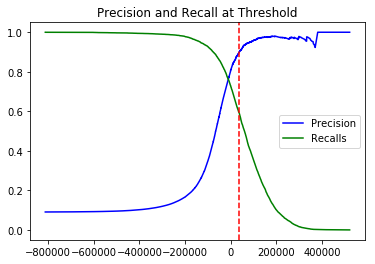

In [23]:
from sklearn.metrics import precision_recall_curve

# From scores & train result, get precision/recall for each threshold points
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

i = 56000
print("{:.2f} {:.2f} {:.2f}".format(thresholds[i], precisions[i], recalls[i]))

# len(thresholds) = len(precision) - 1
plt.title("Precision and Recall at Threshold")
plt.plot(thresholds, precisions[:-1], "b", label="Precision")
plt.plot(thresholds, recalls[:-1], "g", label="Recalls")
plt.axvline(x=thresholds[i], color="r", linestyle="--")
plt.legend()

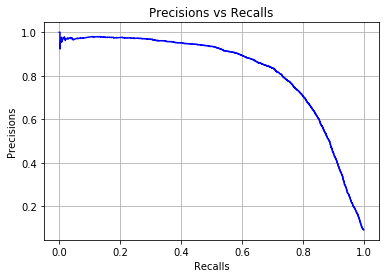

In [24]:
plt.plot(recalls, precisions, "b")
plt.xlabel('Recalls')
plt.ylabel('Precisions')
plt.title("Precisions vs Recalls")
plt.grid()

In [25]:
# Get threshold at specified Precisions (Get first index of max value -- True)
t_95 = thresholds[np.argmax(precisions >= 0.95)]
t_95

84195.75770566695

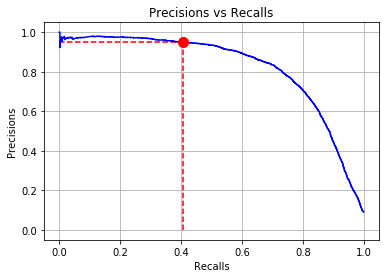

In [26]:
i_95 = np.argmax(thresholds > t_95)

plt.plot(recalls, precisions, "b")
plt.xlabel('Recalls')
plt.ylabel('Precisions')
plt.title("Precisions vs Recalls")

plt.plot(recalls[i_95],0.95, "ro", markersize=10)
plt.hlines(0.95, 0, recalls[i_95], color='r', linestyle="--")
plt.vlines(recalls[i_95], 0, 0.95, color='r', linestyle="--")

plt.grid()

### Receiver Operating Characteristic (ROC) and AUC

This plots true-positive rate (Recall) vs. false-positive rate ( FP / (FP + TP) --> 1 - TN / (TN + FN)  )

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

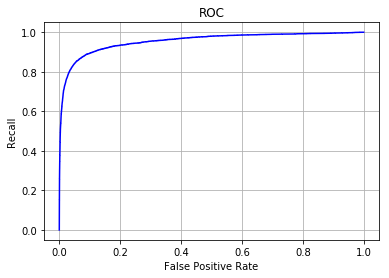

In [28]:
plt.plot(fpr, tpr, "b")
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title("ROC")
plt.grid()

# A perfect classifier would have Recall = 1, FPR = 0 (All recalled, no false positive
# An Area under ROC curve (AOC) represents how close we are to this ideal value

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9548904906112023

### Usage 
* Precision vs Recall when Positive class is rare (or care more about false positive)
* ROC otherwise
* In above example where 5 is rare, PR shows more that improvement is needed

## Multiclass

In [30]:
sgd_multi = SGDClassifier(random_state=4, tol=1000)
sgd_multi.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=4, shuffle=True, tol=1000,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
sgd_multi.predict(X[0:1])

array([5], dtype=uint8)

In [45]:
sgd_multi.classes_ ## Different classes of data

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
sgd_multi.decision_function(X[0:1]) 

array([[-230518.70063968, -380324.3257642 , -193393.24142479,
         -25707.98970812, -366304.18686757,   50673.29649029,
        -268463.02908598, -194528.71242952, -228654.68290488,
        -299032.66861713]])

In [50]:
## All decision functions of each class (this is index of classes_)
df_max_idx = np.argmax(sgd_multi.decision_function(X[0:1]))
sgd_multi.classes_[df_max_idx]

5

### Adjust

In [52]:
cross_val_score(sgd_multi, X_train, y_train, cv=3, scoring="accuracy")

array([0.87142571, 0.87754388, 0.87968195])

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
  ('scaler', StandardScaler()),
])

X_train_processed = pipeline.fit_transform(X_train)

In [55]:
cross_val_score(sgd_multi, X_train_processed, y_train, cv=3, scoring="accuracy")

array([0.90716857, 0.90914546, 0.9126869 ])

### Error Analysis

In [56]:
y_train_pred = cross_val_predict(sgd_multi, X_train_processed, y_train, cv=3)
conf_multi = confusion_matrix(y_train, y_train_pred)
conf_multi

## Row -> Actual
## Col -> Predictions

array([[5722,    2,   30,   11,   10,   47,   47,    9,   42,    3],
       [   1, 6471,   39,   28,    6,   44,    8,   14,  121,   10],
       [  49,   37, 5350,   91,   78,   25,   86,   63,  164,   15],
       [  49,   41,  142, 5322,    3,  250,   35,   54,  135,  100],
       [  17,   22,   41,    8, 5353,   10,   55,   31,   92,  213],
       [  72,   37,   42,  173,   79, 4632,  102,   29,  163,   92],
       [  34,   24,   44,    2,   42,   94, 5630,    5,   43,    0],
       [  23,   24,   70,   27,   57,   11,    4, 5813,   17,  219],
       [  53,  155,   73,  157,   18,  158,   50,   27, 5024,  136],
       [  42,   33,   27,   91,  158,   35,    2,  219,   79, 5263]])

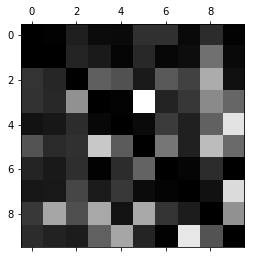

In [70]:
# Normalize actuals

total_actuals = conf_multi.sum(axis=1, keepdims=True)
norm_conf_multi = conf_multi/total_actuals

np.fill_diagonal(norm_conf_multi, 0) ## Need to to zero out this value, to surface other values
plt.matshow(norm_conf_multi, cmap=plt.cm.gray)